/Users/amanmehra/anaconda3/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/amanmehra/anaconda3/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


Saved next_locations_per_pallet.csv with predictions for each pallet's latest timestamp.
Total pallet records: 851
Total violations: 92
Exported 808 unique pallet-to-route mappings to pallet_route_mapping.csv


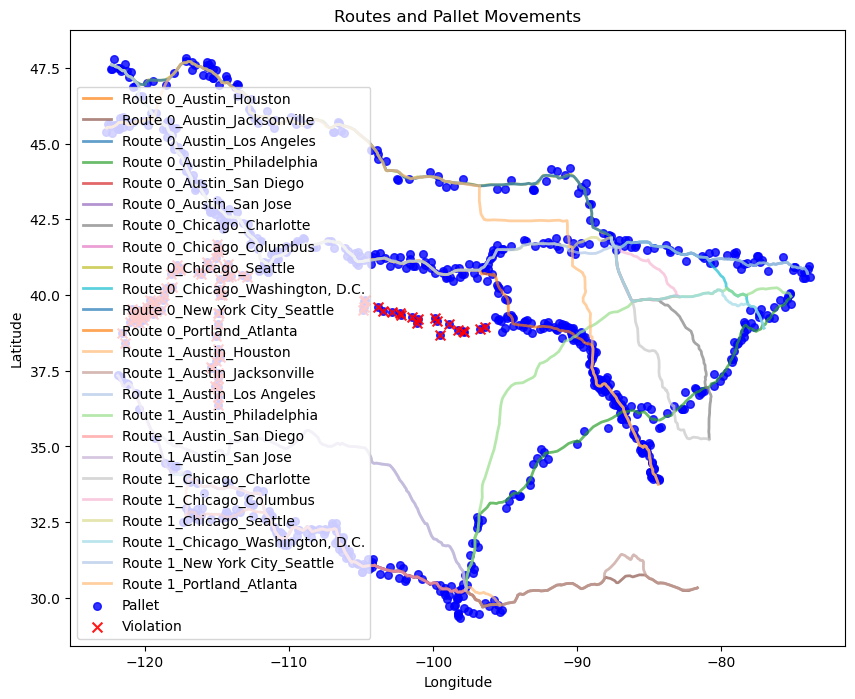

In [10]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Shapely for line-based distance checks
from shapely.geometry import Point, LineString
# Geopy for geodesic distance (used for next location predictions if needed)
from geopy.distance import geodesic

class RouteMapper:
    """
    Class to handle:
    - Building route geometry from historical data.
    - Checking pallet distance to the nearest route (circular threshold).
    - Predicting the next location based on nearest route point and historical timing.
    """

    def __init__(self, threshold=1000000.0):
        """
        Initialize the RouteMapper with a distance threshold (in meters).
        Any pallet point beyond this distance from the route geometry is flagged as deviating.

        Parameters
        ----------
        threshold : float
            The distance (in meters) to treat as the corridor radius.
        """
        self.threshold = threshold
        self.route_dict = {}   # route_id -> list of (timestamp, lat, lon)
        self.route_lines = {}  # route_id -> shapely.LineString (in lat-lon, approximate)

    def build_route_dict(self, historical_df):
        """
        Build an internal dictionary of routes and their LineStrings from the historical DataFrame.

        Parameters
        ----------
        historical_df : pd.DataFrame
            Must have columns: ["Route_ID", "timestamp", "latitude", "longitude"].
        """
        # Ensure timestamps are datetime
        if not np.issubdtype(historical_df["timestamp"].dtype, np.datetime64):
            historical_df["timestamp"] = pd.to_datetime(historical_df["timestamp"])

        # Group points by Route_ID
        route_dict = defaultdict(list)
        for _, row in historical_df.iterrows():
            rid = row["Route_ID"]
            t = row["timestamp"]
            lat = row["latitude"]
            lon = row["longitude"]
            route_dict[rid].append((t, lat, lon))
        
        # Sort each route by timestamp
        for rid in route_dict:
            route_dict[rid].sort(key=lambda x: x[0])

        self.route_dict = dict(route_dict)

        # Build a Shapely LineString for each route (warning: lat-lon is planar in Shapely)
        for rid, points in self.route_dict.items():
            if len(points) < 2:
                self.route_lines[rid] = None  # Not enough points to make a line
            else:
                # Shapely convention: (x, y) = (longitude, latitude)
                coords = [(p[2], p[1]) for p in points]  # p = (time, lat, lon)
                line = LineString(coords)
                self.route_lines[rid] = line

    def _approx_distance_degrees_to_meters(self, dist_degrees, lat):
        """
        Convert a planar 'dist_degrees' difference to approximate meters at latitude 'lat'.
        This is a rough approach for smaller geographic regions. For large/accurate distances,
        use a local projection or pyproj.
        """
        # ~111,320 meters per degree latitude
        lat_factor = 111320.0
        # for longitude, ~111,320 * cos(lat)
        lon_factor = 111320.0 * np.cos(np.radians(lat))

        # We take an average to get a rough scale factor
        mean_factor = (lat_factor + lon_factor) / 2.0
        dist_meters = dist_degrees * mean_factor
        return dist_meters

    def _distance_to_route_line(self, route_id, lat, lon):
        """
        Compute the shortest distance from (lat, lon) to the route's LineString (in approximate meters).
        If the route has no valid LineString, return inf.
        """
        line = self.route_lines.get(route_id, None)
        if not line:
            return float('inf')

        pallet_point = Point(lon, lat)  # (x=lon, y=lat) in degrees
        dist_degrees = pallet_point.distance(line)  # planar distance in "degrees"
        dist_meters = self._approx_distance_degrees_to_meters(dist_degrees, lat)
        return dist_meters

    def _get_nearest_route(self, lat, lon):
        """
        Find the route that yields the minimal distance from (lat, lon) to the route's LineString.
        Returns (best_route_id, min_dist).
        """
        best_route_id = None
        min_dist = float('inf')
        for route_id in self.route_dict:
            d = self._distance_to_route_line(route_id, lat, lon)
            if d < min_dist:
                min_dist = d
                best_route_id = route_id
        return best_route_id, min_dist

    def detect_deviation(self, lat, lon):
        """
        Check if the current pallet position (lat, lon) is deviating from
        the nearest route by more than self.threshold meters.

        Returns
        -------
        (route_id, dist, is_deviating)
        """
        route_id, dist = self._get_nearest_route(lat, lon)
        if route_id is None:
            return (None, float('inf'), True)
        is_dev = (dist > self.threshold)
        return (route_id, dist, is_dev)

    def _geodesic_distance(self, lat1, lon1, lat2, lon2):
        """
        For next-location prediction, we still might want geodesic 
        distance between points for tie-breaking or checks.
        """
        return geodesic((lat1, lon1), (lat2, lon2)).meters

    def predict_next_location(self, route_id, lat, lon, current_time=None):
        """
        Predict the next location along the given route, based on historical time intervals.

        Steps:
         1) Find the nearest route point i to (lat, lon) by geodesic distance.
         2) If i+1 exists, compute how long it took historically (t2 - t1),
            add that dt to current_time for your predicted time.
         3) Return (pred_time, pred_lat, pred_lon).

        If no valid next point, returns (None, None, None).
        """
        if route_id not in self.route_dict:
            return (None, None, None)

        points = self.route_dict[route_id]
        if not points:
            return (None, None, None)

        # Find nearest route point by geodesic distance
        best_index = -1
        min_dist = float('inf')
        for i, (rt, rlat, rlon) in enumerate(points):
            dist = self._geodesic_distance(lat, lon, rlat, rlon)
            if dist < min_dist:
                min_dist = dist
                best_index = i

        if best_index < 0:
            return (None, None, None)

        # If there's a "next" point in the route
        if best_index < len(points) - 1:
            t1, lat1, lon1 = points[best_index]
            t2, lat2, lon2 = points[best_index + 1]
            dt = (t2 - t1).total_seconds()
            if dt < 0:
                # If times are reversed or zero, fallback
                return (t2, lat2, lon2)

            if current_time is not None:
                pred_time = current_time + pd.Timedelta(seconds=dt)
            else:
                pred_time = t2

            return (pred_time, lat2, lon2)
        else:
            # We're at or beyond the last route point in historical data
            t_last, lat_last, lon_last = points[-1]
            return (t_last, lat_last, lon_last)

def plot_routes_and_pallets(
    historical_df, 
    ongoing_df, 
    violated_df=None, 
    color_by_route=True
):
    """
    Visualize routes on a map:
      - If color_by_route=True, each route is plotted in a different color.
      - Otherwise, routes are plotted in gray.
      - Ongoing pallet points are in blue, violations in red (if any).

    Parameters
    ----------
    historical_df : pd.DataFrame
        Has columns ["Route_ID", "timestamp", "latitude", "longitude"].
    ongoing_df : pd.DataFrame
        Has columns ["Pallet_ID", "timestamp", "latitude", "longitude"].
    violated_df : pd.DataFrame or None
        Has columns ["Pallet_ID", "timestamp", "latitude", "longitude", "dist", "Route_ID"].
    color_by_route : bool
        If True, each route ID is given a distinct color.
    """
    plt.figure(figsize=(10, 8))

    # Plot historical routes
    if color_by_route:
        unique_routes = historical_df["Route_ID"].unique()
        cmap = plt.get_cmap("tab20")
        route_color_map = {}
        for i, rid in enumerate(unique_routes):
            route_color_map[rid] = cmap(i % 20)

        for route_id, group in historical_df.groupby("Route_ID"):
            group_sorted = group.sort_values("timestamp")
            clr = route_color_map[route_id]
            plt.plot(
                group_sorted["longitude"], 
                group_sorted["latitude"], 
                color=clr, alpha=0.7, linewidth=2, label=f"Route {route_id}"
            )
    else:
        # single color (gray) for all routes
        for route_id, group in historical_df.groupby("Route_ID"):
            group_sorted = group.sort_values("timestamp")
            plt.plot(group_sorted["longitude"], group_sorted["latitude"], 
                     color="gray", alpha=0.5, linewidth=1, label="_nolabel_")

    # Plot ongoing pallet points in blue
    plt.scatter(
        ongoing_df["longitude"], 
        ongoing_df["latitude"], 
        color="blue", s=30, alpha=0.8, label="Pallet"
    )
    
    # If violations DataFrame is provided, plot them in red
    if violated_df is not None and not violated_df.empty:
        plt.scatter(
            violated_df["longitude"], 
            violated_df["latitude"], 
            color="red", s=50, alpha=0.9, marker="x", label="Violation"
        )
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Routes and Pallet Movements")

    # Build a legend with unique labels
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), loc="best")
    plt.show()

def export_pallet_to_route_mapping(results_df, output_file="pallet_route_mapping.csv"):
    """
    Export a CSV showing which Pallet_ID is matched to which Route_ID (plus other fields).

    We assume `results_df` has at least: ["Pallet_ID", "matched_route"].
    """
    mapping_df = results_df.copy()
    # Remove duplicates so each (Pallet_ID, matched_route) is listed once
    mapping_df = mapping_df.drop_duplicates(subset=["Pallet_ID", "matched_route"])
    mapping_df.to_csv(output_file, index=False)
    print(f"Exported {len(mapping_df)} unique pallet-to-route mappings to {output_file}")

def main():
    # 1. Load data
    historical_data = pd.read_csv("known_route_repo.csv")
    ongoing_data = pd.read_csv("On-going trip data.csv")

    # Convert timestamps to datetime if needed
    historical_data["timestamp"] = pd.to_datetime(historical_data["timestamp"], errors="coerce")
    ongoing_data["timestamp"] = pd.to_datetime(ongoing_data["timestamp"], errors="coerce")

    # 2. Create RouteMapper with threshold = 500m
    mapper = RouteMapper(threshold=100000.0)
    mapper.build_route_dict(historical_data)

    all_results = []
    violations = []

    # 3. Check each row in ongoing data for deviation
    for idx, row in ongoing_data.iterrows():
        pid = row["Pallet_ID"]
        plat = row["latitude"]
        plon = row["longitude"]
        ptime = row["timestamp"]

        # Detect deviation using line-based distance
        route_id, dist, is_dev = mapper.detect_deviation(plat, plon)

        # Create a result record
        rec = {
            "Pallet_ID": pid,
            "timestamp": ptime,
            "latitude": plat,
            "longitude": plon,
            "matched_route": route_id,
            "distance_to_route": dist,
            "is_deviating": is_dev,
            "pred_timestamp": None,
            "pred_lat": None,
            "pred_lon": None
        }

        # Record violation if any
        if is_dev:
            violations.append({
                "Pallet_ID": pid,
                "timestamp": ptime,
                "latitude": plat,
                "longitude": plon,
                "dist": dist,
                "Route_ID": route_id
            })
        
        all_results.append(rec)

    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    violations_df = pd.DataFrame(violations)

    # 4. For the latest timestamp per pallet, do next-location prediction
    next_loc_records = []
    grouped = ongoing_data.groupby("Pallet_ID", as_index=False)
    for pallet_id, group in grouped:
        latest_row = group.loc[group["timestamp"].idxmax()]
        lat = latest_row["latitude"]
        lon = latest_row["longitude"]
        ptime = latest_row["timestamp"]

        route_id, dist, is_dev = mapper.detect_deviation(lat, lon)
        pred_time, pred_lat, pred_lon = (None, None, None)
        if route_id is not None:
            pred_time, pred_lat, pred_lon = mapper.predict_next_location(route_id, lat, lon, current_time=ptime)

        next_loc_records.append({
            "Pallet_ID": pallet_id,
            "current_timestamp": ptime,
            "current_lat": lat,
            "current_lon": lon,
            "matched_route": route_id,
            "distance_to_route": dist,
            "is_deviating": is_dev,
            "pred_timestamp": pred_time,
            "pred_lat": pred_lat,
            "pred_lon": pred_lon
        })

    next_loc_df = pd.DataFrame(next_loc_records)
    next_loc_df.to_csv("next_locations_per_pallet.csv", index=False)
    print("Saved next_locations_per_pallet.csv with predictions for each pallet's latest timestamp.")

    # 5. Save the main results and violations
    results_df.to_csv("full_results.csv", index=False)
    violations_df.to_csv("violations.csv", index=False)
    print(f"Total pallet records: {len(results_df)}")
    print(f"Total violations: {len(violations_df)}")

    # 6. (Optional) Export pallet->route mapping
    export_pallet_to_route_mapping(results_df, "pallet_route_mapping.csv")

    # 7. (Optional) Visualize
    plot_routes_and_pallets(historical_data, ongoing_data, violations_df, color_by_route=True)

if __name__ == "__main__":
    main()


In [3]:
pip install shapely

  Obtaining dependency information for shapely from https://files.pythonhosted.org/packages/15/63/eef4f180f1b5859c70e7f91d2f2570643e5c61e7d7c40743d15f8c6cbc42/shapely-2.0.7-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
